In [88]:
'''
Setup google creds
'''
#gcloud auth application-default login
#gcloud config set project 'oceanic-beach-419220'
#gcloud auth application-default set-quota-project 'oceanic-beach-419220'

'\nSetup google creds\n'

In [89]:
import pandas as pd
import numpy as np
import os
import io

In [3]:
from google.cloud import storage , aiplatform
import json

storage_unit = storage.Client()
buckets = storage_unit.list_buckets()

bucket_names = []

for bucket in buckets:
    bucket_names.append(bucket.name)

In [4]:
bucket_names

['cloud-ai-platform-59e1a667-b40c-40cd-af10-d868d795abdb',
 'credentials_2024_educative']

In [5]:
bucket = storage_unit.bucket(bucket_names[-1])
data_blob = storage_unit.list_blobs(bucket_names[-1])

for blob in data_blob:
    if blob.name == 'credentials_2024_educative':
        # print(blob.download_as_text())
        credentials_data = json.loads(blob.download_as_text())
    # elif blob.name == 'preprocessed_data.csv':
    #     df = pd.read_csv(blob.download_to_file())

In [6]:
project_id = credentials_data['PROJECT_ID']
bucket_id = credentials_data['BUCKET_ID']
region = credentials_data['REGION']

In [94]:
data = pd.read_csv(r'C:\csulb_projects\projects\learning project\churn_prediction_gcp\data/customer_churn_dataset.csv')
data.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [95]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,440832.0,225398.667955,129531.918550,2.0,113621.75,226125.5,337739.25,449999.0
Age,440832.0,39.373153,12.442369,18.0,29.00,39.0,48.00,65.0
Tenure,440832.0,31.256336,17.255727,1.0,16.00,32.0,46.00,60.0
Usage Frequency,440832.0,15.807494,8.586242,1.0,9.00,16.0,23.00,30.0
Support Calls,440832.0,3.604437,3.070218,0.0,1.00,3.0,6.00,10.0
Payment Delay,440832.0,12.965722,8.258063,0.0,6.00,12.0,19.00,30.0
Total Spend,440832.0,631.616223,240.803001,100.0,480.00,661.0,830.00,1000.0
Last Interaction,440832.0,14.480868,8.596208,1.0,7.00,14.0,22.00,30.0
Churn,440832.0,0.567107,0.495477,0.0,0.00,1.0,1.00,1.0


<Axes: >

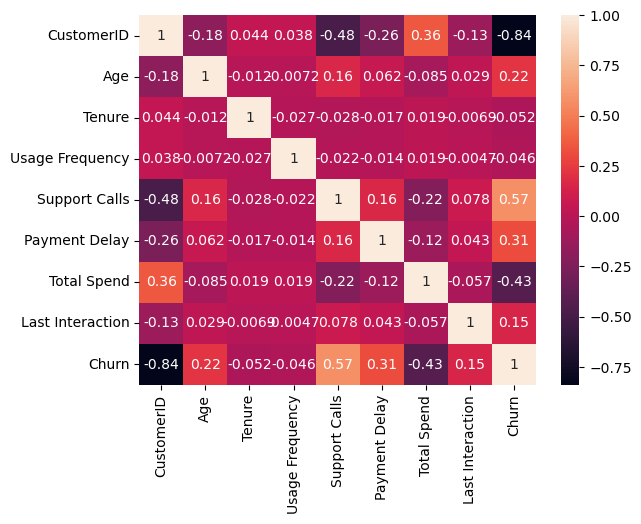

In [96]:
import seaborn as sns
sns.heatmap(data.select_dtypes(include='number').corr(),annot=True)

In [97]:
numerical_df = data.select_dtypes(include='number')
numerical_df.drop('CustomerID',axis=1,inplace=True)
outlier_columns = []

for columns in numerical_df:
    md_values = np.ma.array(numerical_df[columns].values).compressed()
    median_values = numerical_df[columns].median()
    temp_df = pd.DataFrame()
    temp_df['temp_values'] = md_values - median_values
    z_scores = temp_df['temp_values'].median()
    if z_scores > 3:
        outlier_columns.append(columns)

In [98]:
data.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [99]:
data.dropna(inplace=True)

In [100]:
data.drop('CustomerID',axis=1,inplace=True)

In [101]:
data.columns = ['_'.join(column.split(' ')) if len(column.split(' '))==2 else column for column in data.columns ]

In [102]:
categorical_colums = data.select_dtypes(include='object').columns
numerical_columns = data.select_dtypes(include='number').columns

In [103]:
features = data.drop('Churn',axis=1)
labels = data['Churn']

In [104]:
'''Upload file to bucket'''
def upload_object(file_path,bucket_name,destination_blob):

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob)

    generation_match_precondition = 0

    try:
        blob.upload_from_filename(file_path,if_generation_match=generation_match_precondition)
        return True
    except Exception as e:
        raise(e)

In [121]:
data.reset_index(drop=True,inplace=True)

In [123]:
# upload_object('/usercode/user_json.json',bucket_names[0],bucket_names[0])
file_name = 'preprocessed_data.csv'
# data.to_csv('preprocessed_data.csv',index=False)
upload_object('preprocessed_data.csv',bucket_names[-1],file_name)

True

In [106]:
categorical_colums = features.select_dtypes('object').columns
numerical_columns = features.select_dtypes('number').columns

In [107]:
categorical_colums

Index(['Gender', 'Subscription_Type', 'Contract_Length'], dtype='object')

In [110]:
transformations = []

for column in categorical_colums:
    transformations.append({'categorical':{'column_name':column}})

for num_column in numerical_columns:
    transformations.append({'numerical':{'column_name':num_column}})

In [111]:
transformations

[{'categorical': {'column_name': 'Gender'}},
 {'categorical': {'column_name': 'Subscription_Type'}},
 {'categorical': {'column_name': 'Contract_Length'}},
 {'numerical': {'column_name': 'Age'}},
 {'numerical': {'column_name': 'Tenure'}},
 {'numerical': {'column_name': 'Usage_Frequency'}},
 {'numerical': {'column_name': 'Support_Calls'}},
 {'numerical': {'column_name': 'Payment_Delay'}},
 {'numerical': {'column_name': 'Total_Spend'}},
 {'numerical': {'column_name': 'Last_Interaction'}}]

In [124]:
data_path = f'gs://{bucket_names[-1]}/{file_name}'
cloud_dataset = aiplatform.TabularDataset.create(
    display_name = "churn_dataset",
    gcs_source = [data_path]
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/1034812075268/locations/us-central1/datasets/5718231222086270976/operations/3953081886284185600
TabularDataset created. Resource name: projects/1034812075268/locations/us-central1/datasets/5718231222086270976
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/1034812075268/locations/us-central1/datasets/5718231222086270976')


In [148]:
dataset = aiplatform.TabularDataset(cloud_dataset.resource_name)
    
job = aiplatform.AutoMLTabularTrainingJob(
    display_name="train-automl",
    optimization_prediction_type="classification"
)

In [149]:
dataset

resource name: projects/1034812075268/locations/us-central1/datasets/5718231222086270976

In [150]:
model = job.run(
    dataset = dataset,
    target_column = "Churn",
    training_fraction_split=0.6,
    validation_fraction_split=0.2,
    test_fraction_split=0.2,
    budget_milli_node_hours=1000,
    model_display_name="Churn_model",
    disable_early_stopping=False
)

No column transformations provided, so now retrieving columns from dataset in order to set default column transformations.
The column transformation of type 'auto' was set for the following columns: ['Tenure', 'Payment_Delay', 'Age', 'Usage_Frequency', 'Last_Interaction', 'Contract_Length', 'Subscription_Type', 'Total_Spend', 'Support_Calls', 'Gender'].
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/322592347902705664?project=1034812075268
AutoMLTabularTrainingJob projects/1034812075268/locations/us-central1/trainingPipelines/322592347902705664 current state:
3
AutoMLTabularTrainingJob projects/1034812075268/locations/us-central1/trainingPipelines/322592347902705664 current state:
3


KeyboardInterrupt: 

In [10]:
model_id = aiplatform.models.Model.list(filter='display_name=Churn_model')[-1].name

In [11]:
model = aiplatform.Model(model_name=model_id)

In [12]:
#retrive model from model registry
# model = aiplatform.models.Model.get_model(model_name='6011075149028130816')

# def get_model_sample(
#     project: str,
#     model_id: str,
#     location: str = "us-central1",
#     api_endpoint: str = "us-central1-aiplatform.googleapis.com",
# ):
#     # The AI Platform services require regional API endpoints.
#     client_options = {"api_endpoint": api_endpoint}
#     # Initialize client that will be used to create and send requests.
#     # This client only needs to be created once, and can be reused for multiple requests.
#     client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
#     name = client.model_path(project=project, location=location, model=model_id)
#     response = client.get_model(name=name)
#     # print("response:", response)
#     return response , name
    
# model , name = get_model_sample(project_id,'6011075149028130816')

In [13]:
model

resource name: projects/1034812075268/locations/us-central1/models/6011075149028130816

In [14]:
DEPLOYED_NAME = "Churn_prediction"

endpoint = model.deploy(deployed_model_display_name=DEPLOYED_NAME)

Creating Endpoint
Create Endpoint backing LRO: projects/1034812075268/locations/us-central1/endpoints/4015598983568162816/operations/1998801122982100992
Endpoint created. Resource name: projects/1034812075268/locations/us-central1/endpoints/4015598983568162816
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1034812075268/locations/us-central1/endpoints/4015598983568162816')
Deploying model to Endpoint : projects/1034812075268/locations/us-central1/endpoints/4015598983568162816
Using default machine_type: n1-standard-2
Deploy Endpoint model backing LRO: projects/1034812075268/locations/us-central1/endpoints/4015598983568162816/operations/5520616031585828864
Endpoint model deployed. Resource name: projects/1034812075268/locations/us-central1/endpoints/4015598983568162816


In [ ]:
predictions = endpoint.predict(instances=test_data_list)
predictions